<a href="https://colab.research.google.com/github/spregler/Digital-Communications/blob/main/16QAM_Hamming2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

''' Simulation of Gray coded 16-QAM 
    1) Generate random bitstream that represents encoded source symbols
    2a) Modulate binary codewords using a Gray Code
    2b) Modulate binary codewords using a (7,4) Hamming Code
    3a) Pass Gray Code through a Gaussian channel with power = 1/5
    3b) Pass Hamming Code through the same channel
    4) Decode noise corrupted signals at the receiver
    5) Compare BER 
'''

' Simulation of Gray coded 16-QAM \n    1) Generate random bitstream that represents encoded source symbols\n    2a) Modulate binary codewords using a Gray Code\n    2b) Modulate binary codewords using a (7,4) Hamming Code\n    3a) Pass Gray Code through a Gaussian channel with power = 1/5\n    3b) Pass Hamming Code through the same channel\n    4) Decode noise corrupted signals at the receiver\n    5) Compare BER \n'

In [2]:
''' 1) Generate random bitstream that represents encoded source symbols '''

NUM_BITS = 7000
M = 16
k = 4
NUM_SYMBOLS = NUM_BITS//k
np.random.seed = 42

# Create binary array of size num_bits
BIT_SEQ = np.random.randint(2, size=NUM_BITS)

# Create LUT used for modulating siganl. The result of divmod is used to index the LUT in such a way that adjacent signals differ by only 1 bit.
LUT = np.array([-3, -1, 3, 1])

In [3]:
''' 2a) Modulate binary codewords using a Gray Code '''

def Gray(arr):
  # Group bit sequence into groups of 4 using a matrix where each row corresponds to a codeword
  codewords = np.reshape(arr, (NUM_BITS//k, k))
  # Convert from binary to decimal
  codewords_dec = codewords.dot(1 << np.arange(codewords.shape[-1] - 1, -1, -1))

  (x,y) = np.divmod(codewords_dec, 4)

  R = LUT[x] # Real component
  I = LUT[y] # Imaginary component

  signal = R+1j*I

  return signal

In [4]:
''' 2b) Modulate binary codewords using a (7,4) Hamming code '''

# Define Parity matrix
p1 = np.array([[0, 1, 1, 1]]).T
p2 = np.array([[1, 0, 1, 1]]).T
p3 = np.array([[1, 1, 0, 1]]).T
P = np.concatenate((p1, p2, p3), axis=1)


def encode(message):
	# Define Generator Matrix
	G = np.concatenate((P, np.eye(4)), axis=1)
	# Encode message using U=mG
	codeword = []
	for col in range(G.shape[1]):
		codeword.append(int(message.dot(G[:,col]) % 2 ))
	
	return codeword


def hamming_decode(received):
	# Define the check matrix H
	H = np.concatenate((np.eye(3), P.T), axis=1)
	# Define the syndrome 
	syndrome = []
	for col in range(H.T.shape[1]):
		syndrome.append(int(received.dot(H.T[:, col]) % 2))

	''' If the syndrome is all 0s, then the recived message is a valid codeword. Because of the one-to-one correspondence 
	between correctable error patterns and syndromes. '''
	if np.any(syndrome):
		loc = reduce(lambda a,b: 2*a+b, syndrome)-1
		valid_codeword = np.copy(received) 
		valid_codeword[int(loc)] = (valid_codeword[int(loc)] + 1) % 2
		print("Received: ", received, "Corrected: ", valid_codeword)
		return valid_codeword

	else: 
		return received


def Hamming(arr):
  # Group bit sequence into groups of 4 using a matrix where each row corresponds to a codeword
  message = np.reshape(arr, (NUM_BITS//k, k))
  # Iterate through each row of matrix, encoding each 4-bit codeword
  temp = [] 
  for row in message:
    temp.append(encode(np.array(row)))
  # Result is a matrix  where each row corresponds to a 7-bit Hamming code
  codewords = np.array(temp)

  # Convert from binary to decimal
  codewords_dec = codewords.dot(1 << np.arange(codewords.shape[-1] - 1, -1, -1))

  ''' Implement Pregler modulation '''
  # Here, x and y are the quotient and remainder of each 7-bit codeword divided by 8
  (x,y) = np.divmod(codewords_dec, 8)
  
  # For each 7-bit codeword, the result of dividing by 8 is equal to 
  X = np.divide(x,4).astype(int)
  Y = np.divide(y,2).astype(int)

  # Modulate using LUTs
  R = LUT[X]
  I = LUT[Y]
  signal = R+1j*I

  return signal

In [109]:
''' 3a) Pass Gray Code through a Gaussian channel with unit power and variance = 1/5 '''

def addNoise(signal):
  noise = (np.random.randn(NUM_SYMBOLS) + 1j*np.random.randn(NUM_SYMBOLS))/np.sqrt(2)
  noisy_signal = signal + noise

  return signal, noisy_signal


''' Helper function to plot constellation and printe statistics about Gaussian rv '''
def simulate_channel(signal, noisy_signal):
  # Plot constellation
  plt.scatter(noisy_signal.real, noisy_signal.imag, color='blue')
  plt.show()

  # Return statistics about symbols
  data, counts = np.unique(signal, return_counts=True)
  df_describe = pd.DataFrame(counts)
  print(df_describe.describe())

  return 0

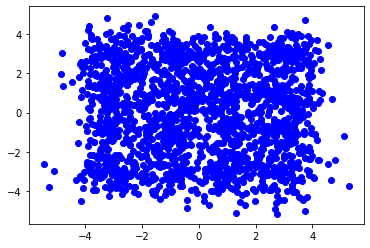

                0
count   16.000000
mean   109.375000
std      8.301606
min     96.000000
25%    104.750000
50%    110.000000
75%    114.250000
max    127.000000


0

In [110]:
''' 3a) Pass Gray Code through a Gaussian channel with power = 1/5 '''
gray_signal, gray_signal_awgn = addNoise(Gray(BIT_SEQ))
simulate_channel(gray_signal, gray_signal_awgn)

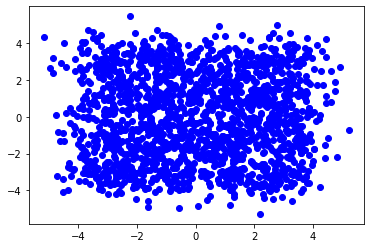

                0
count   16.000000
mean   109.375000
std      8.301606
min     96.000000
25%    104.750000
50%    110.000000
75%    114.250000
max    127.000000


0

In [111]:
''' 3b) Pass Hamming Code through the same channel '''
hamming_signal, hamming_signal_awgn = addNoise(Hamming(BIT_SEQ))
simulate_channel(hamming_signal, hamming_signal_awgn)

In [112]:
gray_signal_awgn.shape

(1750,)

In [115]:
''' 4) Decode noise corrupted signals at the receiver '''
''' Can't get trig to work '''

# Gray
hypothesis = []
def receiver(signal):
  for element in signal:
    if element.real < 0:
      if element.real < -2:
        hypothesis.append([0,0])
      else: 
        hypothesis.append([0,1])

    elif element.real > 0:
      if element.real > 2:
        hypothesis.append([1,0])
      else:
        hypothesis.append([1,1])
    
    if element.imag < 0:
      if element.imag < -2:
        hypothesis.append([0,0])
      else:
        hypothesis.append([0,1])
    
    elif element.imag > 0:
      if element.imag > 2:
        hypothesis.append([1,0])
      else:
        hypothesis.append([1,1])
      
  return hypothesis


result = np.array(receiver(gray_signal_awgn)).reshape(NUM_BITS)
error_cnt = np.count_nonzero(np.bitwise_xor(result, BIT_SEQ))
BER = error_cnt/NUM_BITS
print(BER)

0.057428571428571426


In [114]:
''' Trying to get trig to work '''
listNums = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
temp = []

for i in listNums:
		res = [int(j) for j in list('{0:04b}'.format(listNums[i]))]
		temp.append(res)
	
messageSet = []
for row in np.array(temp):
  messageSet.append(encode(np.array(row)))

# Prototype to use in correlation calculation for signal decision
prototype_dec = np.asarray(messageSet).dot(1 << np.arange(np.asarray(messageSet).shape[-1] - 1, -1, -1))
(w,z) = np.divmod(prototype_dec, 8)
w = np.divide(w,4).astype(int)
z = np.divide(z,2).astype(int)
W = LUT[w]
Z = LUT[z]
prot_signal = W+1j*Z
#
prototype = np.array(list(zip(prot_signal.real, prot_signal.imag)))
received = np.array(list(zip(hamming_signal_awgn.real, hamming_signal_awgn.imag)))
# Dot product now
dot_prod = np.dot(prototype, received.T)
received_norm = np.linalg.norm(received, axis=1)
prototype_norm = np.linalg.norm(prototype, axis=1)
norm_product = np.asarray([received_norm * prototype_norm[i] for i in range(prototype_norm.shape[0])])

dProduct = np.divide(dot_prod.T, norm_product.T)

cosine = np.abs(1 - dProduct)
index_min = np.argmin(cosine, axis=1)

decision = prototype[index_min]

correct_cnt = 0
for idx in range(decision.shape[0]):
  if (decision[idx][0] == hamming_signal.real[idx]) and (decision[idx][1] == hamming_signal.imag[idx]):
    correct_cnt += 1

SER = 1 - correct_cnt/NUM_SYMBOLS
BER = SER/4
print(SER)
print(BER)
print(decision.shape)
print(hamming_signal.shape)

0.44285714285714284
0.11071428571428571
(1750, 2)
(1750,)
